# Imports

In [1]:
import pandas as pd
import numpy as np
import csv
import nltk
import sklearn
import pyphen
import random
import time
import string
import itertools
import time
random.seed(42)

# Scoring

In [2]:
def report_score(gold_labels, predicted_labels, detailed=False):
    macro_F1 = sklearn.metrics.f1_score(gold_labels, predicted_labels, average='macro')
    print("macro-F1: {:.2f}".format(macro_F1))
    if detailed:
        scores = sklearn.metrics.precision_recall_fscore_support(gold_labels, predicted_labels)
        print("{:^10}{:^10}{:^10}{:^10}{:^10}".format("Label", "Precision", "Recall", "F1", "Support"))
        print('-' * 50)
        print("{:^10}{:^10.2f}{:^10.2f}{:^10.2f}{:^10}".format(0, scores[0][0], scores[1][0], scores[2][0], scores[3][0]))
        print("{:^10}{:^10.2f}{:^10.2f}{:^10.2f}{:^10}".format(1, scores[0][1], scores[1][1], scores[2][1], scores[3][1]))
    print()
    
    
def get_score(gold_labels, predicted_labels): 
    macro_F1 = sklearn.metrics.f1_score(gold_labels, predicted_labels, average='macro')
    return macro_F1


# DataSet

In [3]:
import pandas as pd
class Dataset(object):

    def __init__(self, language):
        self.language = language

        trainset_path = "../datasets/{}/{}_Train.tsv".format(language, language.capitalize())
        devset_path = "../datasets/{}/{}_Dev.tsv".format(language, language.capitalize())

        self.trainset = self.read_dataset(trainset_path)
        self.devset = self.read_dataset(devset_path)

    def read_dataset(self, file_path):
        with open(file_path) as file:
            fieldnames = ['hit_id', 'sentence', 'start_offset', 'end_offset', 'target_word', 'native_annots',
                          'nonnative_annots', 'native_complex', 'nonnative_complex', 'gold_label', 'gold_prob']
            
            dataset = pd.read_csv(file, names = fieldnames, sep = "\t")

            #dataset = [sent for sent
        return dataset

# Custom Transformers

In [4]:
# adapted from 
# https://opendevincode.wordpress.com/2015/08/01/building-a-custom-python-scikit-learn-transformer-for-machine-learning/
# and http://michelleful.github.io/code-blog/2015/06/20/pipelines/
# http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html#sphx-glr-auto-examples-hetero-feature-union-py

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from nltk import pos_tag

class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    
    def fit(self, X, *_):
        return self
    
    def transform(self, df):
        return df[self.key]


class POS_Tagger(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, *_):
        return self
    
    def transform(self, X):
        result = []
        for word in X:
            tag = pos_tag([word])[0][1]
            tag_dict = {tag:1}
            result.append(tag_dict)
        return result


class Affix_Extractor(BaseEstimator, TransformerMixin):
    def __init__(self, affix_type):
        self.affix_type = affix_type
    
    def transform(self, X, *_):
        result = []
        for word in X:
            if self.affix_type == "prefix":
                affix = word[:3]
            elif self.affix_type == "suffix":
                affix = word[-3:]
                
            row_dict = {affix:1}
            result.append(row_dict)
        return result
            
    def fit(self, *_):
        return self


class WordFeatureExtractor(BaseEstimator, TransformerMixin):
    # here are my basic features:
        # - len chars = word length
        # - len tokens = phrase length
        # - len uniq =  ratio of unique characters in word
        # - len vowels = ratio of vowels in word
        # - len const = ratio of constonants in word
        # - len syl = number of syllables
        
        # - final baseline system uses tokens, uniq, and const based on feature analyis
        
    def __init__(self,language):
        language = language
        # from 'Multilingual and Cross-Lingual Complex Word Identification' (Yimam et. al, 2017)
        if language == 'english':
            self.avg_word_length = 5.3
        else:  # spanish
            self.avg_word_length = 6.2
            
        self.d = pyphen.Pyphen(lang='en')
    
    def transform(self, X, *_):
        result = []
        for word in X:
            len_chars = len(word) / self.avg_word_length
            len_tokens = len(word.split(' '))
            len_uniq = len(set(word))/len(word)
            len_vowels = len([letter for letter in word.split() if letter in set("aeiou")])/len(word)
            len_const = len([letter for letter in word.split() if letter not in set("aeiou")])/len(word)
            len_syl = len(self.d.inserted(word).split("-"))

            # dictionary to store the features in, in order to access later when testing individual features
            row_dict = {"chars":len_chars,"tokens": len_tokens, "unique": len_uniq,
                        "vowels": len_vowels, "const":len_const, "syl": len_syl,}

            result.append(row_dict)
        return result
    
    def fit(self, *_):
        return self
    

# Model


In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import TruncatedSVD as PCA
from sklearn.ensemble import RandomForestClassifier
import scipy

class DTC_Model(object):

    def __init__(self, language):
        self.language = language
        # from 'Multilingual and Cross-Lingual Complex Word Identification' (Yimam et. al, 2017)
        if language == 'english':
            self.avg_word_length = 5.3
            self.d = pyphen.Pyphen(lang='en')
        else:  # spanish
            self.avg_word_length = 6.2
            self.d = pyphen.Pyphen(lang='es')
            
        
        self.dv = DictVectorizer()
        self.cv = CountVectorizer(ngram_range = (1,3))
        #self.cv = TfidfVectorizer(ngram_range = (2,2))
        #self.model = DecisionTreeClassifier(class_weight = "balanced", random_state=0)
        
        self.model = RandomForestClassifier( n_estimators = 25, random_state=0, class_weight="balanced")
        self.build_pipe()
        
    def build_pipe(self):
        word_features = Pipeline([('select', Selector(key="target_word"))] +
            [( 'wfe', WordFeatureExtractor(self.language) )] +
            [( 'dv', DictVectorizer() )])

        Ngrams = Pipeline([('select', Selector(key = "sentence"))]+
            [('cv', CountVectorizer())])
        
        suffix = Pipeline([('select', Selector(key='target_word'))]+
                          [('suf',Affix_Extractor(affix_type = 'suffix'))]+
                          [( 'dv', DictVectorizer())])
        
        prefix = Pipeline([('select', Selector(key='target_word'))]+
                          [('suf',Affix_Extractor(affix_type = 'prefix'))]+
                          [( 'dv', DictVectorizer())])
        
        char_ngrams = Pipeline([('select', Selector(key = 'target_word'))]+
                              [('cv', CountVectorizer(analyzer = 'char_wb',ngram_range=(2, 3)))])       

        
        f_union = Pipeline([('union', FeatureUnion(transformer_list = [
                            ('words', word_features),('ngrams', Ngrams),
                            ('sffx', suffix), ('pffx', prefix),
                            ('char', char_ngrams)]))])

        
        self.pipe = f_union
        
    def train(self, trainset, *args):
        X = self.pipe.fit_transform(trainset)
        y = trainset['gold_label']
       
        return self.model.fit(X, y)
        
    def test(self, testset, *args):
        X = self.pipe.transform(testset)
        return self.model.predict(X)
    
    def feature_importances(self):
        return self.model.feature_importances_
    

In [6]:
def run_model(language, *args):
    data = Dataset(language)
    print("{}: {} training - {} dev".format(language, len(data.trainset), len(data.devset)))

    model = DTC_Model(language)

    model.train(data.trainset, *args)


    predictions = model.test(data.devset, *args)
    
    gold_labels = data.devset['gold_label']

    #gold_labels = [sent['gold_label'] for sent in data.devset]

    report_score(gold_labels, predictions, detailed = True)
    
    #print(model.feature_importances())
    
    

In [86]:
start = time.time()   

run_model('english',)
run_model('spanish',)

fin = time.time()

print(fin-start)

english: 27299 training - 3328 dev
macro-F1: 0.81
  Label   Precision   Recall      F1     Support  
--------------------------------------------------
    0        0.84      0.84      0.84      1940   
    1        0.77      0.78      0.77      1388   

spanish: 13750 training - 1622 dev
macro-F1: 0.75
  Label   Precision   Recall      F1     Support  
--------------------------------------------------
    0        0.76      0.89      0.82      969    
    1        0.79      0.59      0.68      653    

29.873422145843506


# Learning Curves

In [8]:
#modified from http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.savefig("out.png", bbox_inches = 'tight')
    return plt

language = 'english'
data = Dataset(language)
print("{}: {} training - {} dev".format(language, len(data.trainset), len(data.devset)))

model = DTC_Model(language)

X = model.pipe.fit_transform(data.trainset)
y = data.trainset['gold_label']


title = "Learning Curve of Decision Tree Classifier"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = model.model
#plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)
#plt.show()

english: 27299 training - 3328 dev


In [107]:
plt.show()
estimator = DecisionTreeClassifier(class_weight = "balanced", random_state=0)
tree = estimator.fit(X,y)
tree.get_params()

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 0,
 'splitter': 'best'}

In [109]:
estimator.tree_.max_depth

204

In [130]:
from sklearn.model_selection import validation_curve

estimator = DecisionTreeClassifier(class_weight = "balanced", random_state=0)
indices = np.arange(y.shape[0])
np.random.shuffle(indices)
X, y = X[indices], y[indices]

train_scores, valid_scores = validation_curve(estimator, X, y, "max_depth", np.array((10,50,100,150,200)), )

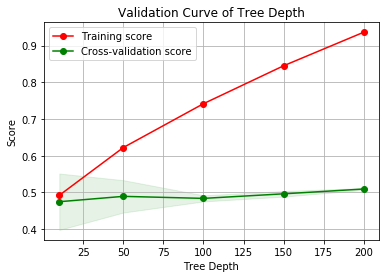

In [124]:
depths = np.array((10,50,100,150,200))
plt.figure()
plt.title("Validation Curve of Tree Depth")

plt.xlabel("Tree Depth")
plt.ylabel("Score")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)
plt.grid()

plt.fill_between(depths, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(depths, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(depths, valid_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.savefig("valid.png", bbox_inches = 'tight')

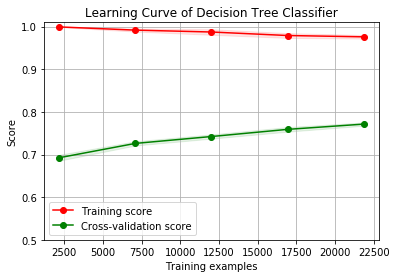

In [132]:
estimator = DecisionTreeClassifier(class_weight = "balanced", max_depth = 100, random_state=0)
plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)
plt.show()

In [137]:
for language in ["english", "spanish"]:
    data = Dataset(language)
    print("{}: {} training - {} dev".format(language, len(data.trainset), len(data.devset)))

    model = DTC_Model(language)
    model.model = DecisionTreeClassifier(class_weight = "balanced", max_depth = 100, random_state=0)

    model.train(data.trainset,)


    predictions = model.test(data.devset,)
    
    gold_labels = data.devset['gold_label']

    #gold_labels = [sent['gold_label'] for sent in data.devset]

    report_score(gold_labels, predictions, detailed = True)

english: 27299 training - 3328 dev
macro-F1: 0.76
  Label   Precision   Recall      F1     Support  
--------------------------------------------------
    0        0.81      0.79      0.80      1940   
    1        0.72      0.73      0.72      1388   

spanish: 13750 training - 1622 dev
macro-F1: 0.68
  Label   Precision   Recall      F1     Support  
--------------------------------------------------
    0        0.75      0.72      0.73      969    
    1        0.61      0.64      0.62      653    



In [138]:
for language in ["english", "spanish"]:
    data = Dataset(language)
    print("{}: {} training - {} dev".format(language, len(data.trainset), len(data.devset)))

    model = DTC_Model(language)
    model.model = DecisionTreeClassifier(class_weight = "balanced", max_depth = 100, max_features = 'auto', random_state=0)

    model.train(data.trainset,)


    predictions = model.test(data.devset,)
    
    gold_labels = data.devset['gold_label']

    #gold_labels = [sent['gold_label'] for sent in data.devset]

    report_score(gold_labels, predictions, detailed = True)

english: 27299 training - 3328 dev
macro-F1: 0.74
  Label   Precision   Recall      F1     Support  
--------------------------------------------------
    0        0.77      0.82      0.79      1940   
    1        0.72      0.66      0.69      1388   

spanish: 13750 training - 1622 dev
macro-F1: 0.66
  Label   Precision   Recall      F1     Support  
--------------------------------------------------
    0        0.73      0.73      0.73      969    
    1        0.60      0.59      0.60      653    



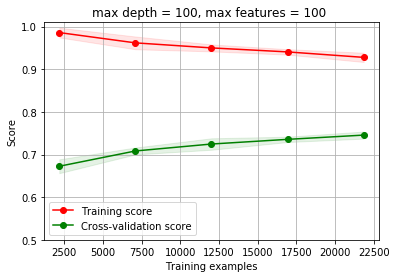

In [168]:
estimator = DecisionTreeClassifier(class_weight = "balanced", max_depth = 100, max_features = 100, random_state=0)
title = ('max depth = 100, max features = 100 ')
plot_learning_curve(estimator, title, X, y,ylim=(0.5, 1.01), cv=cv, n_jobs=4)
plt.show()

In [165]:
for language in ["english", "spanish"]:
    data = Dataset(language)
    print("{}: {} training - {} dev".format(language, len(data.trainset), len(data.devset)))

    model = DTC_Model(language)
    model.model = estimator
    model.train(data.trainset,)


    predictions = model.test(data.devset,)
    
    gold_labels = data.devset['gold_label']

    #gold_labels = [sent['gold_label'] for sent in data.devset]

    report_score(gold_labels, predictions, detailed = True)

english: 27299 training - 3328 dev
macro-F1: 0.76
  Label   Precision   Recall      F1     Support  
--------------------------------------------------
    0        0.80      0.79      0.79      1940   
    1        0.71      0.72      0.72      1388   

spanish: 13750 training - 1622 dev
macro-F1: 0.70
  Label   Precision   Recall      F1     Support  
--------------------------------------------------
    0        0.76      0.76      0.76      969    
    1        0.65      0.64      0.64      653    



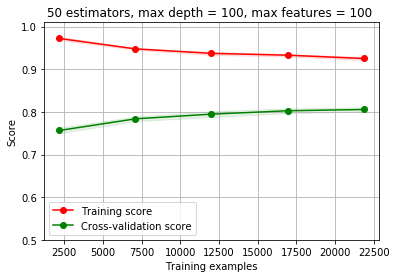

In [23]:
estimator = RandomForestClassifier(n_estimators = 50, max_depth = 50, max_features = 100,random_state=0, class_weight="balanced")
title = ('50 estimators, max depth = 100, max features = 100 ')
plot_learning_curve(estimator, title, X, y,ylim=(0.5, 1.01), cv=cv, n_jobs=4)
plt.show()

In [21]:
for language in ["english", "spanish"]:
    data = Dataset(language)
    print("{}: {} training - {} dev".format(language, len(data.trainset), len(data.devset)))

    model = DTC_Model(language)
    model.model = estimator
    model.train(data.trainset,)


    predictions = model.test(data.devset,)
    
    gold_labels = data.devset['gold_label']

    #gold_labels = [sent['gold_label'] for sent in data.devset]

    report_score(gold_labels, predictions, detailed = True)

english: 27299 training - 3328 dev
macro-F1: 0.80
  Label   Precision   Recall      F1     Support  
--------------------------------------------------
    0        0.83      0.84      0.83      1940   
    1        0.77      0.76      0.76      1388   

spanish: 13750 training - 1622 dev
macro-F1: 0.77
  Label   Precision   Recall      F1     Support  
--------------------------------------------------
    0        0.78      0.91      0.84      969    
    1        0.82      0.62      0.70      653    

